In [1]:
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
res_dir = 'res'
experiments = ['mrcv_mites','mrcv_all','sun_all','sun_mites']
#experiments = ['sun_all','sun_mites']
#res_dir = 'all_res'
path = '../data/shortstack/%s/Results.txt'
path_annotation = '../data/introns.gff3'
path_annotation_promoters = '../data/promoters.gff3'
path_mites = "../data/res/mites_consensus.fasta"
path_mites_res = '../data/res/mites_prod.fasta'
path_res = '../data/res/all_results.csv'
path_mirna_seq = '../data/res/mirna.y.fasta'
path_mirna_seq_trep = '../data/res/mirna.y.trep.fasta'
path_mirna_mites_seq = '../data/res/mirna.mites.y.fasta'
path_mirna_mature = '../data/res/mirna.y.mature.csv'
path_res_seq = '../data/res/all_results.fasta'

path_genome = '../data/Triticum_aestivum.IWGSC.dna.toplevel.fa'
path_blast_res_mirna_mites = '../data/res/blast_mirna_mites.csv'
path_blast_res_mites_mirna = '../data/res/blast_mites_mirna.csv'



path_mirbase = '../data/mature.fa'

In [3]:
### Load shortstack results
dfs = {}
for experiment in experiments:
    experiment_path = path % (experiment,)
    df = pd.read_csv(experiment_path, sep='\t')
    df['Name'] = experiment + '_' + df['Name']
    df['experiment'] = experiment
    print('Experiment:', experiment)
    print('All results:',len(df.index))
    #df = df[df.MIRNA == 'Y']
    #print('Only miRNAs:',len(df.index))
    df = df[df.Reads > 10]
    print('Only hotspots with +10 reads:',len(df.index))
    #df = df[df['21'] > 5]
    #print('Only miRNAs 21nt +5 reads:',len(df.index))
    print('*' * 10)
    dfs[experiment] = df

Experiment: mrcv_mites
All results: 1211339
Only hotspots with +10 reads: 37695
**********
Experiment: mrcv_all
All results: 38532
Only hotspots with +10 reads: 38532
**********
Experiment: sun_all
All results: 157492
Only hotspots with +10 reads: 157492
**********
Experiment: sun_mites
All results: 1211339
Only hotspots with +10 reads: 78708
**********


In [4]:
dfs = [ v for v in dfs.values() ]

In [5]:
df = pd.concat(dfs)
print(len(df.index))
df.head(2)

312427


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,MIRNA,PhaseScore,Short,Long,20,21,22,23,24,experiment
104,1A:1195670-1195768,mrcv_mites_MITE_T_102265|chr6B|218219330|21821...,99,23,0.181,15,0.783,.,AAUGUAAGAUGUUUUUUUGACACU,7,...,N6,0.0,0,0,0,0,1,6,16,mrcv_mites
111,1A:1239059-1239290,mrcv_mites_MITE_T_45812|chr5A|568401370|568401...,232,30,0.235,7,0.833,+,GAGGACGCACUAUAUUUUAGAACG,12,...,N14,-1.0,0,4,0,0,0,1,25,mrcv_mites


In [6]:
#correct name and loci
df['Name'] = df['Name'].str.split('|').str[0]
df['seqname'] = df['#Locus'].str.split(':').str[0]
df['position'] = df['#Locus'].str.split(':').str[1]
df['start'] = df.position.str.split('-').str[0].astype(int)
df['end'] = df.position.str.split('-').str[1].astype(int)
df['Name'] = df['Name'] + '_' + df['seqname'] + '_' + df['start'].astype(str) + '_' + df['end'].astype(str)

In [7]:
df = df.reset_index(drop=True)

In [8]:
df_sep = {}
for seqname in df.seqname.unique():
    df_sep[seqname] = df[df.seqname == seqname]


In [9]:
min_distance = 150
duplicated = []
for k,v in df.iterrows():
    if k in duplicated:
        continue
    other = df_sep[v.seqname]
    other = other[(other.index != k) & 
                (other.MajorRNA == v.MajorRNA) &
                (abs(other.start - v.start) <= min_distance) & 
                (abs(other.end - v.end) <= min_distance)]
    if len(other.index) > 0:
        duplicated += other.index.tolist()

In [10]:
duplicated = set(duplicated)
print(len(duplicated))

31536


In [11]:
print(len(df.index))

312427


In [12]:
df = df[~df.index.isin(duplicated)]
count_total = len(df.index)
count_total

280891

In [13]:
## 

In [14]:
df_y = df[df.MIRNA == 'Y']
print('Y:',len(df_y.index))

Y: 270


In [15]:
df['N'] = 'Y'
df['N'] = df['MIRNA'].str.split('N').str[1]
df['N'].fillna('Y',inplace=True)

In [16]:
df.MIRNA.value_counts()

N6     163879
N11     53007
N5      22553
N2      18426
N14      7355
N13      4901
N12      4763
N15      2081
N3       1834
N4       1576
Y         270
N8        246
Name: MIRNA, dtype: int64

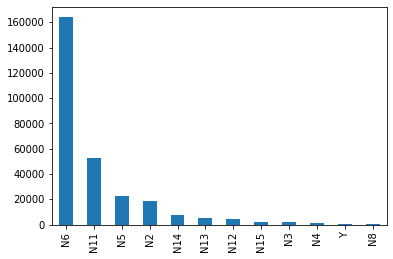

In [17]:
df.MIRNA.value_counts().plot(kind='bar')

In [18]:
df.groupby('DicerCall').count()['Name']


DicerCall
20       231
21     12666
22      1020
23       395
24    248153
N      18426
Name: Name, dtype: int64

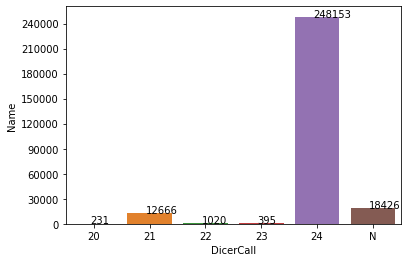

In [19]:
df_plot = df.groupby('DicerCall').count()
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot
ax = sns.barplot(x = df_plot.index, y = df_plot.Name)
x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
pyplot.savefig('../data/res/mirna_sizes.png',transparent=True, bbox_inches='tight', pad_inches=0)

In [20]:
#######################
####  CHECKPOINT  #####
#######################

In [21]:
# SAVE CURRENT STATE

df.to_csv('../data/res/3_ml_checkpoint1.csv', index=None)


In [22]:
# LOAD PREVIOUS STATE
df = pd.read_csv('../data/res/3_ml_checkpoint1.csv')
print(len(df.index))
df.head(2)

280891


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,experiment,seqname,position,start,end,N
0,1A:1195670-1195768,mrcv_mites_MITE_T_102265_1A_1195670_1195768,99,23,0.181,15,0.783,.,AAUGUAAGAUGUUUUUUUGACACU,7,...,0,1,6,16,mrcv_mites,1A,1195670-1195768,1195670,1195768,6
1,1A:1239059-1239290,mrcv_mites_MITE_T_45812_1A_1239059_1239290,232,30,0.235,7,0.833,+,GAGGACGCACUAUAUUUUAGAACG,12,...,0,0,1,25,mrcv_mites,1A,1239059-1239290,1239059,1239290,14


In [23]:
#######################
##  END CHECKPOINT  ###
#######################

0         mrcv_mites
1         mrcv_mites
2         mrcv_mites
3         mrcv_mites
4         mrcv_mites
             ...    
280886     sun_mites
280887     sun_mites
280888     sun_mites
280889     sun_mites
280890     sun_mites
Name: experiment, Length: 280891, dtype: object

In [36]:
#take all microRNA and sample non-miRNA 
dataset = pd.concat([df[df['N'] == 'Y'], df[df['N'] != 'Y'].sample(n=270, random_state=42)])
print(len(dataset.index))

540


In [37]:
dataset.columns

Index(['#Locus', 'Name', 'Length', 'Reads', 'RPM', 'UniqueReads', 'FracTop',
       'Strand', 'MajorRNA', 'MajorRNAReads', 'Complexity', 'DicerCall',
       'MIRNA', 'PhaseScore', 'Short', 'Long', '20', '21', '22', '23', '24',
       'experiment', 'seqname', 'position', 'start', 'end', 'N'],
      dtype='object')

In [38]:
dataset.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,experiment,seqname,position,start,end,N
416,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.0,+,UAGAGAUUUCAAAUGGAACAC,7,...,9,0,0,3,mrcv_mites,1A,169645857-169646029,169645857,169646029,Y
2565,1D:147896240-147896319,mrcv_mites_MITE_T_120271_1D_147896240_147896319,80,45,0.353,1,1.0,+,UAUAUUUUGGUACGGAGGGAU,22,...,38,1,0,0,mrcv_mites,1D,147896240-147896319,147896240,147896319,Y


In [39]:
dataset['Y'] = dataset['N'].apply(lambda x: 1 if x == 'Y' else 0)

In [40]:
dataset['seqname'] = dataset['#Locus'].str.split(':').str[0]
dataset['position'] = dataset['#Locus'].str.split(':').str[1]
dataset['start'] = dataset.position.str.split('-').str[0].astype(int)
dataset['end'] = dataset.position.str.split('-').str[1].astype(int)

In [41]:
#pick just some columns
columns = ['#Locus','experiment','seqname','start','end','Length','Reads','UniqueReads','MajorRNAReads','Short', 'Long', '20', '21', '22', '23', '24','Y']
dataset = dataset[columns]
dataset.head(2)

,#Locus,experiment,seqname,start,end,Length,Reads,UniqueReads,MajorRNAReads,Short,Long,20,21,22,23,24,Y
416,1A:169645857-169646029,mrcv_mites,1A,169645857,169646029,173,16,3,7,0,2,2,9,0,0,3,1
2565,1D:147896240-147896319,mrcv_mites,1D,147896240,147896319,80,45,1,22,0,4,2,38,1,0,0,1


In [42]:
dataset.to_csv('../data/ml_res/dataset.csv', index=None)

In [43]:
dataset

,#Locus,experiment,seqname,start,end,Length,Reads,UniqueReads,MajorRNAReads,Short,Long,20,21,22,23,24,Y
416,1A:169645857-169646029,mrcv_mites,1A,169645857,169646029,173,16,3,7,0,2,2,9,0,0,3,1
2565,1D:147896240-147896319,mrcv_mites,1D,147896240,147896319,80,45,1,22,0,4,2,38,1,0,0,1
4160,2A:168984136-168984233,mrcv_mites,2A,168984136,168984233,98,198,2,86,4,1,1,39,89,63,1,1
8681,3A:19302861-19302943,mrcv_mites,3A,19302861,19302943,83,108,10,89,0,2,0,99,4,0,3,1
10815,3B:253488744-253488823,mrcv_mites,3B,253488744,253488823,80,1099,21,715,2,2,28,1053,10,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107280,2D:405173400-405173854,sun_all,2D,405173400,405173854,455,111,21,20,2,1,1,11,2,15,79,0
124500,3B:707428590-707429274,sun_all,3B,707428590,707429274,685,476,332,156,6,6,6,12,4,35,407,0
80175,1B:674916383-674916876,sun_all,1B,674916383,674916876,494,91,22,12,3,2,2,0,5,8,71,0
273475,7A:339106043-339106429,sun_mites,7A,339106043,339106429,387,48,45,15,1,0,0,2,0,3,42,0
